In [ ]:
import copy
import torch
from torch import nn
from torch import optim
import torchtext
from torchtext import data
from torchtext import datasets

TEXT = data.Field(sequential=True, batch_first=True, lower=True)
LABEL = data.LabelField()

# load data splits
train_data, val_data, test_data = datasets.SST.splits(TEXT, LABEL)

# build dictionary
TEXT.build_vocab(train_data)
LABEL.build_vocab(train_data)

# hyperparameters
vocab_size = len(TEXT.vocab)
label_size = len(LABEL.vocab)
padding_idx = TEXT.vocab.stoi['<pad>']
embedding_dim = 128
hidden_dim = 128

# build iterators
train_iter, val_iter, test_iter = data.BucketIterator.splits(
    (train_data, val_data, test_data),
    batch_size=32)

downloading trainDevTestTrees_PTB.zip


trainDevTestTrees_PTB.zip: 100%|██████████| 790k/790k [00:01<00:00, 738kB/s]


extracting


problem 1


In [ ]:
# pip install torchtext==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.3 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.15.2
    Uninstalling torchtext-0.15.2:
      Successfully uninstalled torchtext-0.15.2


In [ ]:
def train(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    correct_preds = 0
    total_preds = 0

    for batch in iterator:
        optimizer.zero_grad()
        text = batch.text
        predictions = model(text).squeeze(1)
        loss = criterion(predictions, batch.label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        # Calculate training accuracy
        preds = torch.argmax(predictions, dim=1)
        correct_preds += (preds == batch.label).sum().item()
        total_preds += len(batch.label)

    accuracy = correct_preds / total_preds
    return epoch_loss / len(iterator), accuracy


def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    correct_preds = 0
    total_preds = 0

    with torch.no_grad():
        for batch in iterator:
            text = batch.text
            predictions = model(text).squeeze(1)
            loss = criterion(predictions, batch.label)
            epoch_loss += loss.item()

            # Calculate accuracy
            preds = torch.argmax(predictions, dim=1)
            correct_preds += (preds == batch.label).sum().item()
            total_preds += len(batch.label)

    accuracy = correct_preds / total_preds
    return epoch_loss / len(iterator), accuracy


In [ ]:
class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, label_size, padding_idx):
        super(RNNClassifier, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.label_size = label_size
        self.num_layers = 1
        # 1. Embedding Layer
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim, padding_idx=padding_idx)

        self.rnn = nn.RNN(self.embedding_dim, self.hidden_dim, self.num_layers, batch_first=True)
        self.fc1 = nn.Linear(self.hidden_dim, self.hidden_dim+200)
        self.fc2= nn.Linear(self.hidden_dim+200, self.label_size)


    def zero_state(self, batch_size):
        # implement the function, which returns an initial hidden state.
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim)
        return h0


    def forward(self, text):

        embedded = self.embedding(text)


        batch_size = text.size(0)
        h0 = self.zero_state(batch_size)
        rnn_out, _ = self.rnn(embedded, h0)

        final_hidden_state = rnn_out[:, -1, :]

        x = self.fc1(final_hidden_state)
        logits=self.fc2(x)

        return logits

In [ ]:

model = RNNClassifier(vocab_size, embedding_dim, hidden_dim, label_size, padding_idx)

In [ ]:
optimizer = optim.Adagrad(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
N_EPOCHS = 15
train_acc_arr=[]
val_acc_arr=[]
train_lss_arr=[]
test_lss_arr=[]
test_acc_arr=[]
val_lss_arr=[]

for epoch in range(N_EPOCHS):

    train_loss, train_acc = train(model, train_iter, optimizer, criterion)  # Pass device
    val_loss, val_acc = evaluate(model, val_iter, criterion)
    test_loss, test_acc = evaluate(model, test_iter, criterion)
    test_lss_arr.append(test_loss)
    test_acc_arr.append(test_acc)
    train_acc_arr.append(train_acc)
    val_acc_arr.append(val_acc)
    train_lss_arr.append(train_loss)
    val_lss_arr.append(val_loss)
    print("Epoch",epoch)
    print("Train loss",train_loss,"Train acc",train_acc*100)
    print("Val loss",val_loss,"Val acc",val_acc*100)
    print("Test loss",test_loss,"Test acc",test_acc*100)



Epoch 0
Train loss 1.0492707017655676 Train acc 0.4173689138576779
Val loss 1.046569788455963 Val acc 0.44232515894641233
Test loss 1.0325618045670646 Test acc 0.4479638009049774
Epoch 1
Train loss 1.0471150966619285 Train acc 0.42275280898876405
Val loss 1.0555036067962646 Val acc 0.44141689373297005
Test loss 1.0354145339557104 Test acc 0.43981900452488687
Epoch 2
Train loss 1.0459663383523177 Train acc 0.4229868913857678
Val loss 1.0512072648320878 Val acc 0.4032697547683924
Test loss 1.0411345848015376 Test acc 0.41312217194570133
Epoch 3
Train loss 1.0461015513773715 Train acc 0.4226357677902622
Val loss 1.063601963860648 Val acc 0.40417801998183467
Test loss 1.0414196525301251 Test acc 0.4144796380090498
Epoch 4
Train loss 1.0462375841337197 Train acc 0.42181647940074907
Val loss 1.0724592890058244 Val acc 0.3923705722070845
Test loss 1.0447675117424555 Test acc 0.4104072398190045
Epoch 5
Train loss 1.045390568199229 Train acc 0.4243913857677903
Val loss 1.0772142393248423 Val ac

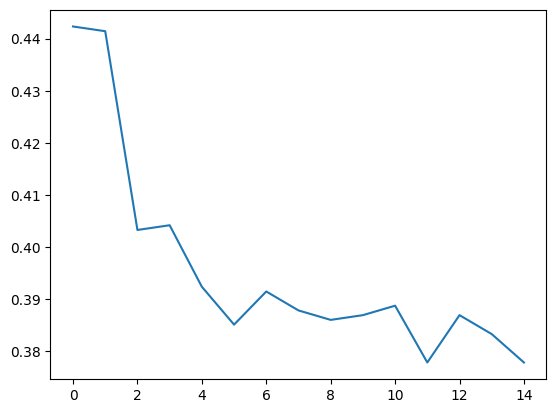

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
x_xis=np.arange(0,15)
plt.plot(x_xis,val_acc_arr)

Training with different model for higher degree of accuracy
1. implemented bi directional LSTM
2. Implemented Adam Optimizer
3. Parallely analysed GRU, RNN and LSTM. I my overall inference I found LST

In [ ]:
class ImprovedRNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, label_size, padding_idx, num_layers=2, dropout=0.5):
        super(ImprovedRNNClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        # Embedding Layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)

        # Bidirectional LSTM
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers,
                            batch_first=True, dropout=dropout, bidirectional=True)

        # Fully connected layer - we multiply hidden_dim by 2 because of bidirectionality
        self.fc = nn.Linear(hidden_dim * 2, label_size)

        # Dropout layer for regularization
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        # Word embeddings
        embedded = self.dropout(self.embedding(text))

        # LSTM outputs
        lstm_out, _ = self.lstm(embedded)

        # We use the final hidden state from both the forward and backward LSTM
        final_hidden_state = torch.cat((lstm_out[:, -1, :self.hidden_dim], lstm_out[:, 0, self.hidden_dim:]), dim=1)

        # Classification
        logits = self.fc(self.dropout(final_hidden_state))

        return logits

embedding_dim = 256
hidden_dim = 89
num_layers = 2
dropout = 0.3
lr = 0.001


In [ ]:
# Parameters

# Initialize model, criterion, and optimizer
model = ImprovedRNNClassifier(vocab_size, embedding_dim, hidden_dim, label_size, padding_idx, num_layers, dropout)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()


N_EPOCHS = 10

for epoch in range(N_EPOCHS):
    train_loss, train_acc = train(model, train_iter, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_iter, criterion)
    test_loss, test_acc = evaluate(model, test_iter, criterion)
    print(f"Epoch: {epoch+1:02}")
    print(f"\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%")
    print(f"\tVal Loss: {val_loss:.3f} | Val Acc: {val_acc*100:.2f}%")

Epoch: 01
	Train Loss: 1.040 | Train Acc: 45.95%
	Val Loss: 1.008 | Val Acc: 53.13%
Epoch: 02
	Train Loss: 0.951 | Train Acc: 57.48%
	Val Loss: 0.934 | Val Acc: 59.40%
Epoch: 03
	Train Loss: 0.837 | Train Acc: 64.48%
	Val Loss: 0.975 | Val Acc: 60.40%
Epoch: 04
	Train Loss: 0.746 | Train Acc: 68.59%
	Val Loss: 1.055 | Val Acc: 61.31%
Epoch: 05
	Train Loss: 0.667 | Train Acc: 71.98%
	Val Loss: 1.034 | Val Acc: 63.12%
Epoch: 06
	Train Loss: 0.620 | Train Acc: 73.75%
	Val Loss: 1.011 | Val Acc: 61.85%
Epoch: 07
	Train Loss: 0.574 | Train Acc: 74.86%
	Val Loss: 1.316 | Val Acc: 61.04%
Epoch: 08
	Train Loss: 0.540 | Train Acc: 76.70%
	Val Loss: 1.301 | Val Acc: 60.67%
Epoch: 09
	Train Loss: 0.503 | Train Acc: 78.72%
	Val Loss: 1.342 | Val Acc: 60.22%
Epoch: 10
	Train Loss: 0.486 | Train Acc: 79.26%
	Val Loss: 1.421 | Val Acc: 59.40%
